In [153]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms 
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np 
import matplotlib.pyplot as plt 
import time
from PIL import Image
import os 
from collections import Counter
import torch.optim as optim
from torchvision.models import VGG16_Weights
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve,  auc
from sklearn.preprocessing import label_binarize

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 244)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    
])

In [155]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')


training data: 4861
validation data: 1620
test data: 1625


In [157]:
##* datasets loader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 224, 244])
tensor(-2.1179) tensor(2.6400)
images shapes: torch.Size([32, 3, 224, 244])


In [158]:
#* pretrained model for vgg16 
num_classes = len(train_dataset.classes)
vgg16_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = vgg16_model.to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.00001) #TODO test with different optimizers 
#optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epoch = 20


In [160]:
#* we need to train the module 

def train_model(model, train_loader, criterion, optimizer, device):
    

        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        #* starting with the gradient from  the intial point 0 
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [161]:
### evaluation the model

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [162]:
#* class for the early stopping 
class EarlyStopping:
    def __init__(self, patience =5, delta = 0, path='best.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
        
           
            self.best_loss = val_loss 
            self.Save_best_model(model)
            self.counter = 0
        else: 
            self.counter += 1 
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
                     

In [163]:
start_time = time.time()
earlyStopping = EarlyStopping(patience=5,  path='best_vgg16.pth')
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    epoch_start_time = time.time()
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 
    
    epoch_end_time = time.time()

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
    
end_time = time.time()
print(f'Total training time: {end_time - start_time:.2f} seconds')

Epoch 1/20: Train Loss: 0.0168 Train Acc: 77.9058, Val Loss: 0.0067, Val Acc: 92.7160
Epoch 2/20: Train Loss: 0.0066 Train Acc: 92.4501, Val Loss: 0.0052, Val Acc: 94.1975
Epoch 3/20: Train Loss: 0.0045 Train Acc: 95.0010, Val Loss: 0.0040, Val Acc: 95.3704
Epoch 4/20: Train Loss: 0.0037 Train Acc: 96.1942, Val Loss: 0.0034, Val Acc: 96.1728
Epoch 5/20: Train Loss: 0.0032 Train Acc: 96.4822, Val Loss: 0.0035, Val Acc: 96.2963
Early stopping counter: 1 out of 5
Epoch 6/20: Train Loss: 0.0026 Train Acc: 97.1199, Val Loss: 0.0031, Val Acc: 96.6049
Epoch 7/20: Train Loss: 0.0025 Train Acc: 97.2434, Val Loss: 0.0033, Val Acc: 96.3580
Early stopping counter: 1 out of 5
Epoch 8/20: Train Loss: 0.0020 Train Acc: 97.7165, Val Loss: 0.0033, Val Acc: 96.5432
Early stopping counter: 2 out of 5
Epoch 9/20: Train Loss: 0.0017 Train Acc: 98.0457, Val Loss: 0.0029, Val Acc: 96.7284
Epoch 10/20: Train Loss: 0.0016 Train Acc: 98.2308, Val Loss: 0.0032, Val Acc: 96.7284
Early stopping counter: 1 out of 5

In [185]:
vgg16_model.load_state_dict(torch.load('best_vgg16.pth',  weights_only=True))
model = vgg16_model.to(device)

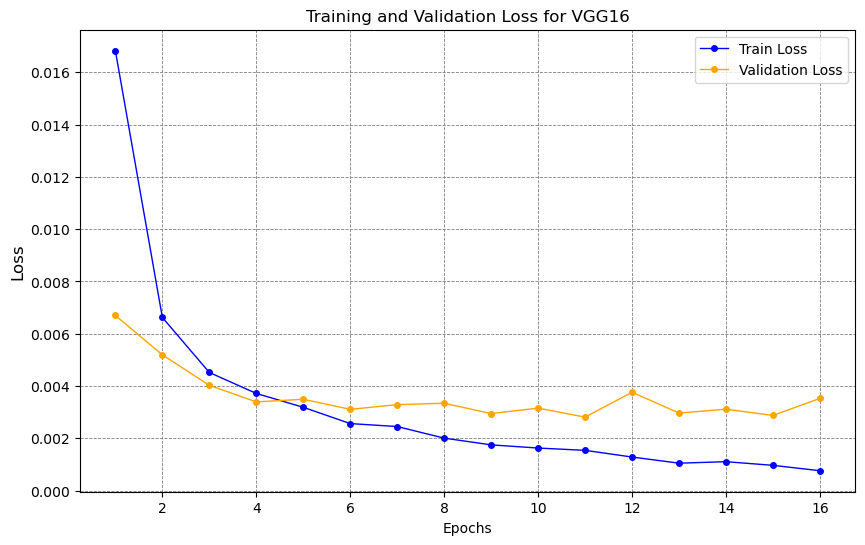

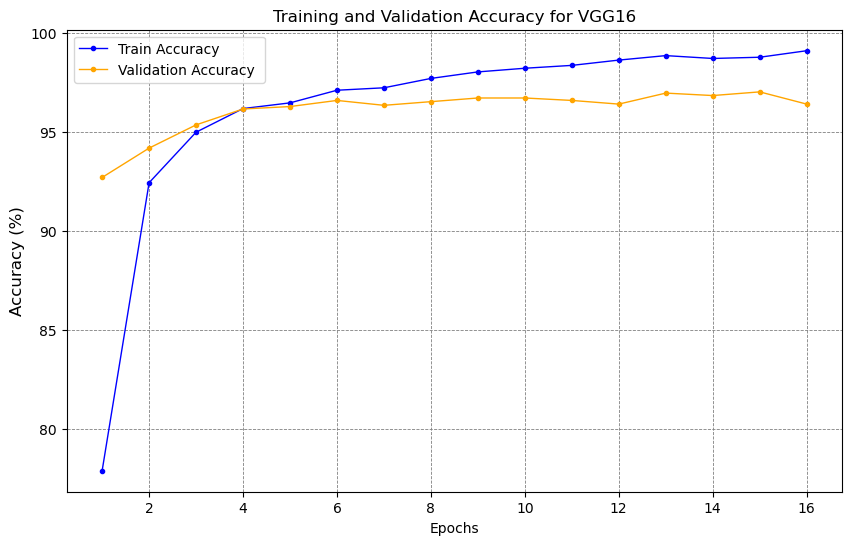

In [192]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
   
    epoch =range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss for VGG16')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    
    plt.show()
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy for VGG16')

    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()


Plot_metrics(train_losses, val_losses,  train_accs,  val_accs)

In [187]:
# evaluation 

#*  Model evaluation 
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [189]:
## testing accuracy 
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.2f}% AUC: {auc:.2f}')

Test Accuaracy: 97.97% AUC: 1.00


Accuracy: 0.9796923076923076

 classification Report
              precision    recall  f1-score   support

     COVID19     0.9754    0.9975    0.9863       398
      Normal     0.9728    0.9704    0.9716       405
   Pneumonia     0.9705    0.9705    0.9705       407
Tuberculosis     1.0000    0.9807    0.9903       415

    accuracy                         0.9797      1625
   macro avg     0.9797    0.9798    0.9797      1625
weighted avg     0.9798    0.9797    0.9797      1625



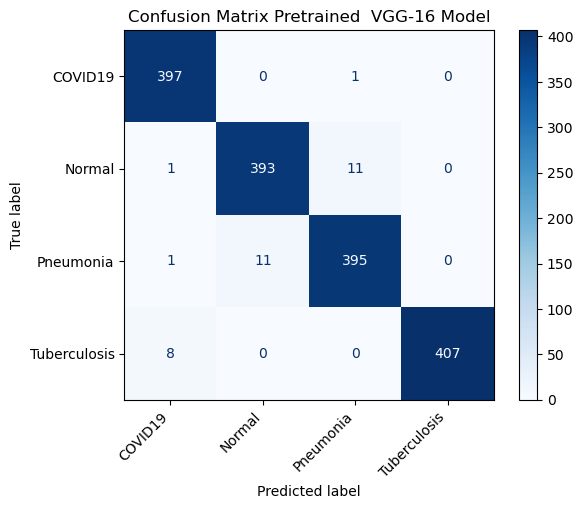

In [191]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels, target_names=train_dataset.classes, digits=4)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  VGG-16 Model')

plt.show()

In [197]:
#* plotting auc curve for each classes 

#* plotting auc curve for each classes 

def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    """
    Plot ROC curve for each class.
    Args:
        all_labels: Ground truth labels.
        all_probs: Predicted probabilities for each class.
        num_classes: Total number of classes.
        class_names: List of class names corresponding to the classes.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(4, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve for VGG16')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


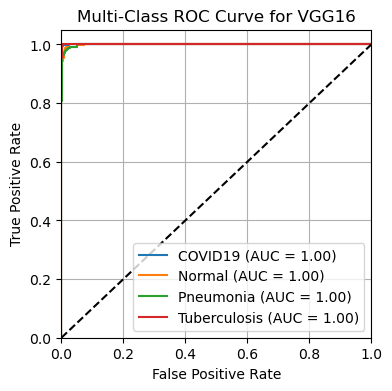

In [198]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes  # Class names
plot_roc_curve(all_labels, all_probs, num_classes, class_names)